In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from backtest import Strategy, InferenceStrategy, MeanReverseStrategy

PRICE_DEC = 1
SIZE_DEC = 3
TEST_FRAC = 0.15

PERIODS = {
    'long': 90,
    'short': 10
}

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

/Users/pgm/miniforge3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

def round_pred(y_pred, minstep = 0.5):
    return np.round(y_pred / minstep) * minstep

In [3]:
df = pd.read_csv('../../bars/bitmex-XBTUSD-1min.csv', parse_dates=['time'])
df.sort_values('time', ignore_index=True, inplace=True)
df.drop_duplicates(subset='time', ignore_index=True, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567865 entries, 0 to 567864
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        567865 non-null  datetime64[ns]
 1   open        567865 non-null  float64       
 2   high        567865 non-null  float64       
 3   low         567865 non-null  float64       
 4   close       567865 non-null  float64       
 5   avg         567865 non-null  float64       
 6   wavg        567865 non-null  float64       
 7   median      567865 non-null  float64       
 8   sum_vol     567865 non-null  int64         
 9   up_sum_vol  567865 non-null  int64         
 10  md_sum_vol  567865 non-null  int64         
 11  lo_sum_vol  567865 non-null  int64         
 12  net_vol     567865 non-null  int64         
 13  up_net_vol  567865 non-null  int64         
 14  md_net_vol  567865 non-null  int64         
 15  lo_net_vol  567865 non-null  int64         
 16  cn

Пропусков в самих данных также нет. 
Имеем дело со следующими столбцами:

| наименование | тип | описание |
|--------------|-------|--------|
|`time`        | datetime   | время начала периода (бара) |
|`open`        | float      | цена первой сделки периода   |    
|`high`        | float      | максимальная цена сделки периода |
|`low`         | float      | минимальная цена сделки периода   |    
|`close`       | float      | цена последней сделки периода |
|`avg`         | float      | средняя цена сделок периода |
|`wavg`        | float      | средневзвешенная по объему цена сделок периода |
|`median`      | float      | медиана цен сделок периода |
|`sum_vol`     | float      | сумма объемов сделок периода |
|`up_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `high` до `max(open, close)`      |
|`md_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `open` до `close`         |
|`lo_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `low` до `min(open, close)` |
|`net_vol`     | float      | нетто-объем сделок периода (сумма объемов покупок минус сумма объемов продаж) |
|`up_net_vol`  | float      | нетто-объемо сделок в промежутке цен от `high` до `max(open, close)`        |
|`md_net_vol`  | float      | нетто-объем сделок в промежутке цен от `open` до `close`     |
|`lo_net_vol`  | float      | нетто-объемо сделок в промежутке цен от `low` до `min(open, close)`   |      
|`cnt`         | int        | количество сделок за период|
|`hbl`         | boolean    | цена `high` была достигнута раньше, чем цена `low`, 

Важный нюанс - perpetual фьючерсы `XBTUSD` и `ETHUSD` на бирже `Bitmex` являются **инверсными**, т.е. единица лота в них не сама криптовалюта, а доллар, а PnL, наоборот, рассчитывается и начисляется в криптовалюте. Это стандартная практика для криптовалютных бирж, которые не могут рассчитывать и начислять PnL в фиате или аналогичных фиату стебл-коинах. В случае `ETHUSD` все еще сложнее, ведь его лот привязан к долларовому выражению `BTC`. Поэтому пока не будем трогать `ETHUSD`, но для `XBTUSD` лоты пересчитаем в единицы криптовалюты, чтобы было: 
* единообразно по всем биржам в данном проекте
* проще для рассчетов PnL в моделях
* проще для восприятия

In [5]:
for col in df.columns:
    if col[-4:] == '_vol':
        df[col] = np.round(df[col] / df.close, SIZE_DEC)

In [6]:
df.sample(5)

,time,open,high,low,close,avg,wavg,median,sum_vol,up_sum_vol,md_sum_vol,lo_sum_vol,net_vol,up_net_vol,md_net_vol,lo_net_vol,cnt,hbl
200839,2021-05-20 12:40:00,41889.0,41889.0,41846.5,41854.0,41861.8,41862.6,41859.0,18.731,0.000,14.902,3.829,-4.494,0.000,-5.054,0.559,261,True
46068,2021-02-01 23:48:00,33529.5,33540.5,33517.5,33539.5,33531.0,33533.3,33530.0,28.180,13.535,8.478,6.167,-10.704,-13.503,2.764,0.035,98,True
181385,2021-05-06 23:53:00,56545.0,56545.0,56513.0,56513.5,56523.7,56518.0,56513.5,17.728,0.000,17.648,0.080,11.656,0.000,11.736,-0.080,85,True
238859,2021-06-15 22:28:00,40103.5,40118.0,40085.0,40085.0,40099.0,40095.5,40100.0,17.016,2.762,14.255,0.000,-10.740,-1.744,-8.996,0.000,59,True
523965,2021-12-31 10:06:00,48278.0,48278.0,48268.0,48268.0,48274.9,48277.3,48278.0,3.936,0.000,3.936,0.000,-3.936,0.000,-3.936,0.000,32,True


## Наивные модели

В качестве самого первого приближения возьмем тривиальную модель - будем считать, что лучшее предсказание цены закрытия следующего периода - цена закрытия текущего периода.

Для удобства обработки тривиальных моделей сразу разобьем целевой ряд (`close`) на тренировочную (85%) и тестовую (15%) выборки. Метрику качества возьмем `MAPE`. Все замеры метрик качества будем проводить на тестовой выборке, чтобы результат можно было сравнивать между моделями

In [7]:
prev_close = df.close.shift(1)
TEST_SIZE = int(TEST_FRAC * len(df.close))
TRAIN_SIZE = len(df.close) - TEST_SIZE
df_train = df.close[:TRAIN_SIZE]
df_test = df.close[TRAIN_SIZE:]
y_pred = prev_close[TRAIN_SIZE:]

In [8]:
mape0 = round(mape(df_test, y_pred) * 100, 6)
print(f'MAPE naive: {mape0}%')

MAPE naive: 0.062579%


`MAPE` чуть больше **0,06%**. Кажется неплохим результатом, но посмотрим разпределение ошибки предсказания:

<AxesSubplot:xlabel='close'>

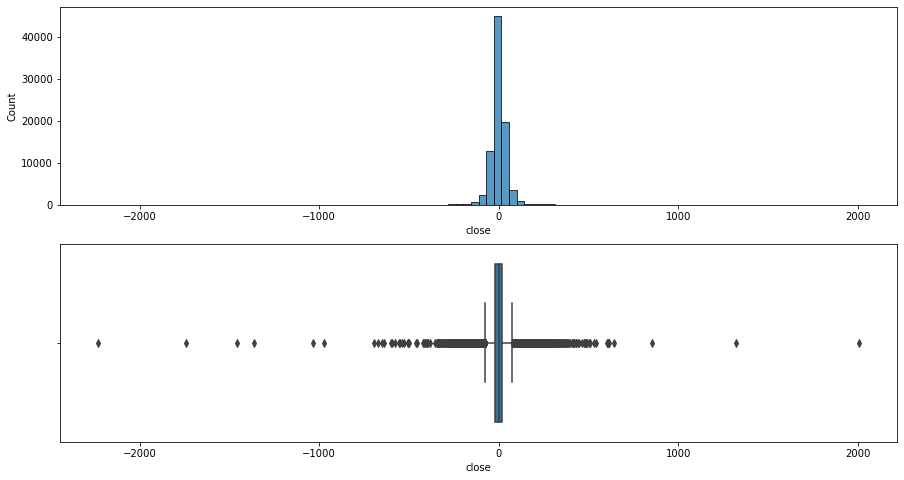

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(15,8))
sns.histplot(ax=ax[0],data=(df_test-y_pred), bins=100)
sns.boxplot(ax=ax[1], x=(df_test-y_pred))

Из хороших новостей - ошибка не выглядит смещенной. Из плохих - у ошибки толстые хвосты распределения.
Что, собственно, логично - такая модель предсказывает более-менее только на низкой волатльности (в отсутствии новостей).

В качестве второй наивной модели попробуем обучить стандартную финансовую модель `ARIMA`. Из EDA секции мы знаем, что ранг интегрированности ценового ряда равен 1, а поэтому необходимо использовать модель `ARIMA(p, 1, q)`. Параметры p и q попробуем отыскать подбором.

In [10]:
# model = pm.auto_arima(df.close, start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=1,              # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)

# print(model.summary())

Лучший результат показывает модель `ARIMA(1,1,3)`. Проверим качество этой модели.

In [11]:

model = ARIMA(df_train, order=(1,1,3))

In [12]:
ers = model.fit()
y_pred = ers.extend(df_test).predict()

In [13]:
y_pred = round_pred(y_pred)
mape1 = round(mape(df_test, y_pred) * 100, 6)
print(f'MAPE ARIMA: {mape1}%')

MAPE ARIMA: 0.06262%


<AxesSubplot:>

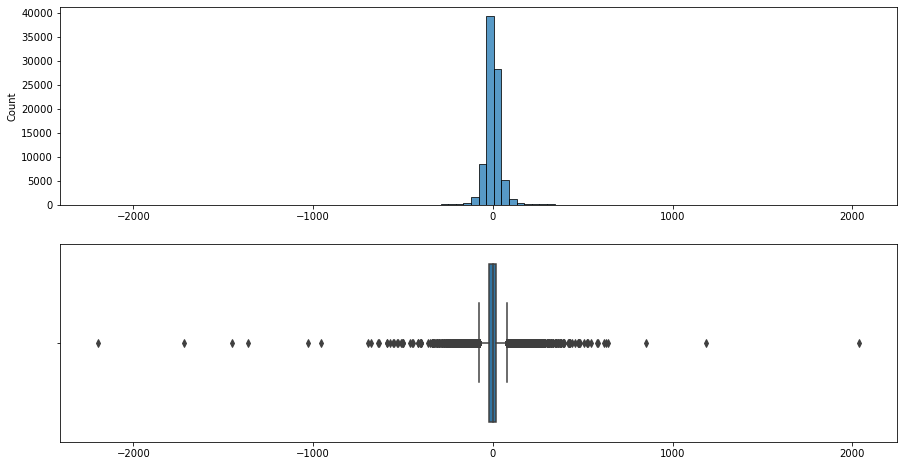

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(15,8))
sns.histplot(ax=ax[0],data=(df_test-y_pred), bins=100)
sns.boxplot(ax=ax[1], x=(df_test-y_pred))

Результат даже хуже, чем у сосвсем тривиальной модели.

In [15]:
cnt_up = 0
cnt_down = 0

def count_up_bars(x):
    global cnt_up
    cnt_up = (cnt_up + 1) if x > 0 else 0
    return cnt_up


def count_down_bars(x):
    global cnt_down
    cnt_down = (cnt_down + 1) if x < 0 else 0
    return cnt_down

In [16]:
temp = prev_close[TRAIN_SIZE:]

In [17]:
prev_close = df.close.shift(1)
diff_close = df.close.diff()
df['up_in_row'] = diff_close.apply(count_up_bars)
df['down_in_row'] = diff_close.apply(count_down_bars)
df['TR'] = np.maximum(df.high, prev_close) - np.minimum(df.low, prev_close)

In [18]:
for key in PERIODS.keys():
    roll = df.rolling(PERIODS[key], min_periods=1)
    df[f'avg_{key}'] = roll.close.mean()
    df[f'std_{key}'] = roll.close.std()
    df[f'ATR_{key}'] = roll.TR.mean()
    df[f'high_{key}'] = roll.high.max()
    df[f'low_{key}'] = roll.low.min()
    df[f'sum_vol_{key}'] = roll.sum_vol.sum()
    df[f'net_vol_{key}'] = roll.net_vol.sum()

In [19]:
df.head(5)

,time,open,high,low,close,avg,wavg,median,sum_vol,up_sum_vol,...,low_long,sum_vol_long,net_vol_long,avg_short,std_short,ATR_short,high_short,low_short,sum_vol_short,net_vol_short
0,2021-01-01 00:00:00,28951.0,29004.0,28950.5,29004.0,28970.2,28978.9,28971.0,34.307,0.000,...,28950.5,34.307,23.374,29004.000,NaN,NaN,29004.0,28950.5,34.307,23.374
1,2021-01-01 00:01:00,29004.0,29050.0,29003.5,29043.5,29032.4,29034.1,29037.5,114.616,33.262,...,28950.5,148.923,105.040,29023.750,27.930718,46.500000,29050.0,28950.5,148.923,105.040
2,2021-01-01 00:02:00,29043.5,29044.0,29016.5,29017.0,29032.4,29033.4,29033.5,42.060,0.178,...,28950.5,190.983,77.923,29021.500,20.130822,37.000000,29050.0,28950.5,190.983,77.923
3,2021-01-01 00:03:00,29016.5,29026.0,29000.0,29016.0,29014.4,29014.3,29016.0,23.823,8.347,...,28950.5,214.806,82.767,29020.125,16.665208,33.333333,29050.0,28950.5,214.806,82.767
4,2021-01-01 00:04:00,29016.0,29016.5,29015.0,29015.0,29016.0,29016.0,29016.0,15.981,0.185,...,28950.5,230.787,67.159,29019.100,14.613350,25.375000,29050.0,28950.5,230.787,67.159
